# Embedding Model and The Dataset Class

In this notebook we develop the next step in our GNN model. To apply either the _meta-layer_ approch or the  or the _ParticleNet_ approch we need to first have a graph structure in hand. 

Comming up with direct mehods to make a graph structure from the processed event data is not encouraged, considering the huge number of hits / nodes ($\approx 10^6$). Direct method's like compaeing distances and angles are computatinally expensive. Insted we train a multylayer perceptron (MLP) in such a way so that points belonging to the same track are close in the latent space, which will allow us to apply a effective knn algorithm to construct the graph strcuture. 
This intermidiate ML model is reffered to as the embeddding model. [1]

[1] : Ju, Xiangyang, et al. "Performance of a geometric deep learning pipeline for HL-LHC particle tracking." The European Physical Journal C 81 (2021): 1-14.

In [1]:
import os
import time
import random
import numpy as np

from scipy.stats import ortho_group

from typing import Optional, Tuple


import torch
import torch.nn as nn
from torch.linalg import norm 
import torch.utils.data as data
import torch.nn.functional as F
from torch.nn import Linear, ReLU, BatchNorm1d, Module, Sequential
from torch import Tensor

# torch.set_default_dtype(torch.float64)

from torch_geometric.typing import (
    Adj,
    OptPairTensor,
    OptTensor,
    Size,
    SparseTensor,
    torch_sparse,
)

import torch_geometric
from torch_geometric.data import Data
from torch_geometric.data import Batch
import torch_geometric.transforms as T
from torch.utils.data.sampler import SubsetRandomSampler
from torch_geometric.utils import remove_self_loops, to_dense_adj, dense_to_sparse, is_undirected , to_undirected, contains_self_loops , to_networkx
from torch_geometric.loader import DataLoader
from torch_geometric.nn import MessagePassing, global_mean_pool, knn_graph
from torch_geometric.datasets import QM9
# from torch_scatter import scatter
# from torch_cluster import knn

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
# import uproot
import vector
vector.register_awkward()
import awkward as ak

from IPython.display import HTML

print("PyTorch version {}".format(torch.__version__))
print("PyG version {}".format(torch_geometric.__version__))

PyTorch version 2.6.0
PyG version 2.6.1


In [2]:
seed = 5 
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(seed)
random.seed(seed)

In [3]:
from tqdm import trange, tqdm

In [4]:
from TrackML import Preprocessing
from TrackML.Models.utils import buildMLP 

In [5]:
# set default params for matplotlib : 
plt.rcParams['font.size'] = 14
plt.rcParams['lines.linewidth'] = 2
plt.rcParams["figure.figsize"] = (10,7)

In [6]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

Using device: mps


In [7]:
from sklearn.preprocessing import StandardScaler

### 1. Define Point Cloud Class for Processed Data 
We define a point cloud dataset class to train our embedding model with. 

In [8]:
detector_path = '../data/detectors.csv'
dataset_path = '../data/train_100_events/'

In [9]:
class PointCloudData(data.Dataset): 
    
    # initialize the dataset class : 
    def __init__(self,dataset_path:str,detector_path:str,min_nhits=3)->None:
        '''
        dataset_path : path to the dataset with the events. 
        eventids : list of eventid identifiers. 
        '''
        super().__init__()
        
        self.dataset_path = dataset_path
        self.min_nhits = min_nhits 
        
        
        self.detector = Preprocessing.load_detector_data(detector_path) 
        
        # get the list of event ids from the dataset folder : 
        eventids = [ code[:-9] for code in os.listdir(dataset_path) if code.endswith('-hits.csv') ]
        self.eventids = eventids
        
        
    def __len__(self)->int: 
        return len( self.eventids )
    
    def __getitem__(self, index):
        return (
            Preprocessing.process_event_data(
                train_path=self.dataset_path, 
                eventid=self.eventids[index], 
                detector=self.detector
            ), 
            Preprocessing.process_particle_labels(
                train_path=self.dataset_path, 
                eventid=self.eventids[index], 
                min_nhits=self.min_nhits 
            )
        )

In [10]:
point_cloud_dataset = PointCloudData(dataset_path,detector_path)
len(point_cloud_dataset)

100

In [11]:
def collate_function(data_list:list): 
    # since we only indend to use batch size of 1 
    # for the embedding layer.
    return data_list[0]

In [12]:
# initialize the data loader object ! 
point_clout_data_loder = data.DataLoader(
    dataset=point_cloud_dataset, 
    batch_size=1, 
    shuffle=True , 
    collate_fn=collate_function
)

In [13]:
node_feats , labels  = next(iter(point_clout_data_loder))
node_feats.shape , labels.shape 

(torch.Size([120246, 15]), torch.Size([120246]))

### 2. Create the Base Embedding Model.

The model architecture is just a normal MLP with relu acctivation for hidden layers

In [14]:
class EmbeddingModel(nn.Module):
    
    def __init__(
        self, 
        in_features:int, 
        hidden_features:list, 
        out_features:int 
    )->None:
        
        super().__init__()
        
        # define the MLP layer : 
        self.MLP = buildMLP(
            insize=in_features, 
            outsize=out_features, 
            features=hidden_features,
            add_bnorm=False
        )
        
    def forward(self,x:Tensor)->Tensor: 
        out =  self.MLP(x)
        out = (out - out.mean(dim=0,keepdim=True))/out.std(dim=0,keepdim=True)
        return out 

In [15]:
example_embedding_model = EmbeddingModel(
    in_features=15, 
    hidden_features=[20,25,15,10],
    out_features=5
)
example_embedding_model

EmbeddingModel(
  (MLP): Sequential(
    (0): Linear(in_features=15, out_features=20, bias=True)
    (1): ReLU()
    (2): Linear(in_features=20, out_features=25, bias=True)
    (3): ReLU()
    (4): Linear(in_features=25, out_features=15, bias=True)
    (5): ReLU()
    (6): Linear(in_features=15, out_features=10, bias=True)
    (7): ReLU()
    (8): Linear(in_features=10, out_features=5, bias=True)
  )
)

In [16]:
node_feats.mean(dim=0 , keepdim=True).shape 

torch.Size([1, 15])

In [17]:
(node_feats/node_feats.std(dim=0 , keepdim=True)).shape

torch.Size([120246, 15])

In [18]:
example_model_out = example_embedding_model(node_feats)
example_model_out.shape 

torch.Size([120246, 5])

### 3. Latent Space Analysis 

Here we create a graph structure by using a _radius\_graph_ algorithm, on the latent space featuers. We set the radius hyperparameter same as the margin for our pairwise hinge loss function (more on that later). 

In [19]:
margin = .01
max_num_neighbors=12

radius_graph_edge_index = torch_geometric.nn.pool.radius_graph(
    example_model_out, 
    r = margin , 
    loop = False , 
    max_num_neighbors=max_num_neighbors
)
radius_graph_edge_index
radius_graph_edge_index.shape 

torch.Size([2, 1127435])

In [20]:
example_model_out.shape

torch.Size([120246, 5])

In [21]:
# check if the graph is undirected 
is_undirected( radius_graph_edge_index )

False

In [22]:
# convert the graph to a directed one 
radius_graph_edge_index = to_undirected( radius_graph_edge_index )
radius_graph_edge_index.shape 

torch.Size([2, 1372226])

In [23]:
# Now each pair had a duplicate copy in the indices list, 
# since the graph is undirected now. 
row , col = radius_graph_edge_index

# Create a mask to get those pairs which have different 
# labels and avoid repeations by choosing row < col
mask = ( row < col ) & ( labels[row] != labels[col] )

negetive_pair_indices = radius_graph_edge_index[:,mask]
del mask , row , col 

In [24]:
negetive_pair_indices.shape

torch.Size([2, 663014])

### 4. Create Custom Loss Function: 

We use pairwise hinge loss functions on all pairs of the hits. For this we use the Hinge Loss (`torch.nn.HingeEmbeddingLoss` see [documentation](https://pytorch.org/docs/stable/generated/torch.nn.HingeEmbeddingLoss.html#torch.nn.HingeEmbeddingLoss)). 

The loss function is given as: 
$$
l_n = \begin{cases}
    x_n, &\text{ if } y_n = 1 \\
    max\{0,\text{margin}-x_n\}, &\text{ if } y_n = -1 
\end{cases}
$$

Note that we cannot afford to calculate pairwise distance for all the hit pairs in the latent space, since that is computationally too expenceive. Insted we calculate the loss using a trick to optimize the calculation. 

We seperately calculate the loss for all the correct hit pairs and calculate the loss for all the incorrect hit pairs that are formed post a knn cluster calculation. This way we avoid the redundent zeros that come up in direct pairwise loss calculations. 

In [25]:
positive_pair_indices = Preprocessing.get_track_index_pairs(labels)

In [26]:
positive_pair_indices.shape , negetive_pair_indices.shape 

(torch.Size([2, 538549]), torch.Size([2, 663014]))

In [27]:
prow , pcol = positive_pair_indices  
nrow , ncol = negetive_pair_indices

# since the arry sizes are too large we apply batching for 
# pairwise distance calculations: 

loss_plus = norm(
    example_model_out[prow , : ] - example_model_out[pcol, :] , 
    ord = 2 , 
    dim = -1 
)

loss_minus = norm(
    example_model_out[ncol,:] - example_model_out[nrow,:], 
    ord = 2 , 
    dim = -1 
)

print( loss_plus , loss_minus )

loss = (margin - loss_minus).sum() + loss_plus.sum()

loss 

tensor([0.0342, 0.0725, 0.1242,  ..., 0.2918, 0.3060, 0.0141],
       grad_fn=<LinalgVectorNormBackward0>) tensor([0.0088, 0.0049, 0.0026,  ..., 0.0074, 0.0022, 0.0047],
       grad_fn=<LinalgVectorNormBackward0>)


tensor(846610.5625, grad_fn=<AddBackward0>)

In [28]:
def EmbeddingLossFunction(
        x:Tensor,
        labels:Tensor,
        radius_graph_edge_index:Tensor,
        margin:float=.01
    )->Tensor: 
    '''
    x  : model output in the latent space. shape = [nhits, out_feats]
    radius_graph_edge_index : graph formed with the radius ball algorithm. 
    positive_idx : pairs of indices of hits sharing the same 
        particle id. shape = [2,num_positive_pairs]. 
    negetive_idx : pairs of hits indices within the latent space 
        margin radius ball having different particle ids. 
    returns : the pair wise hinge loss. 
    '''
    
    radius_graph_edge_index = to_undirected( radius_graph_edge_index )
    
    # get the positive indices 
    positive_idx = Preprocessing.get_track_index_pairs(labels)
    
    # get the negetive indices pairs that lie within the margin ball : 
    row , col = radius_graph_edge_index

    # Create a mask to get those pairs which have different 
    # labels and avoid repeations by choosing row < col
    mask = ( row < col ) & ( labels[row] != labels[col] )
    negetive_idx = radius_graph_edge_index[:,mask]
    
    # get the positive row and col idx : 
    prow , pcol = positive_idx 
    
    # get the negetive row and col idx : 
    nrow , ncol = negetive_idx
    
    # loss form the positive pairs 
    loss_plus = norm(
    x[prow , : ] - x[pcol, :] , 
    ord = 2 , 
    dim = -1 
    )

    # distance between negetive pairs that lie within the margin
    loss_minus = norm(
        x[ncol,:] - x[nrow,:], 
        ord = 2 , 
        dim = -1 
    )
    
    # final loss 
    loss = torch.log((margin - loss_minus).sum()) + torch.log(loss_plus.sum())

    return loss     

### 5. Define Graph Structure

Use knn statergy in the latent space to create graph structure. 

In [29]:
# def create_graph_structure(latent_space_hits:Tensor,k:int): 
#     return torch_geometric.nn.pool.knn_graph(x = latent_space_hits, k = k )

# k=5 
# example_edge_indeces = create_graph_structure(example_model_out,k=k)
# example_edge_indeces.shape 

# get PyG grapg data structure for the knn buil graph. 
example_graph_data = Data(
    x = node_feats, 
    edge_index=radius_graph_edge_index, 
    y = labels
)

In [30]:
import networkx
from networkx import connected_components

In [31]:
def get_disconnected_components(data:Data):
    # Convert PyG graph to NetworkX graph
    G = to_networkx(data, to_undirected=True)
    
    # Get connected components
    component_list = list(connected_components(G))
    
    # Convert node indices back to PyTorch tensors
    components = [torch.tensor(list(component)) for component in component_list]
    
    return components

example_components = get_disconnected_components(example_graph_data)

In [32]:
len( example_components ),torch.unique(labels).shape 

(7391, torch.Size([9388]))

In [33]:
# get one of these component for metric analysis 
example_component = example_components[0]
print(example_component.shape)

# find the majority particle id that belong to this track: 
component_labels = labels[example_component]
mode , count = torch.mode( component_labels )
mode , count 

torch.Size([286])


(tensor(0), tensor(133))

In [34]:
# accociateed particle with each disconnectde component of the graph : 
accociated_particle = [ torch.mode(labels[component])[0] for component in example_components]
len(accociated_particle) , len(example_components)

(7391, 7391)

### 6. Define Track Metrics

for detais of the metrices used, see [1]. 

[1] Ju, Xiangyang, et al. "Performance of a geometric deep learning pipeline for HL-LHC particle tracking." The European Physical Journal C 81 (2021): page 5.

In [35]:
def event_reconstruction_metrics( graph_data:Data , labels:Tensor )->tuple: 
    '''
        data : graph dataset to get the metrics for : 
        labels : particle_ids for each of the nodes (hits)
        returns : the trajecteory and particle purity of the graph dataset. 
    '''
    
    # get the disconnected compoenents (reconstructed tracks) form the graph steructure : 
    disconnected_components = get_disconnected_components(graph_data)
    
    
    ## 1. get the matched partices for each of the disconnecte graphs : 
    
    #  partices with the max occourence for each of the disconnected components : 
    max_track_particle = torch.tensor([ torch.mode(labels[component])[0] for component in disconnected_components])
    
    # frequency of the particle with the most occourence for each of the disconnected component : 
    max_track_particle_freq = torch.tensor([ torch.sum(track == particle) for particle,track in zip(max_track_particle,disconnected_components)])
    
    # get the number of hits that belong to each reconstructed track : 
    num_hits_tracks = torch.tensor( [component.shape[0] for component in disconnected_components] )
    
    # keep mark for each reconstructed track for which the particle 
    # with the most occourance, makes for at least 50% of all the hits in 
    # the given reconstructed track. 
    # we also exclude particle's with id 0 
    
    mask = ( 2*max_track_particle_freq >= num_hits_tracks ) & ( max_track_particle != 0 )
    
    # total number of true hits left by the underlying max_track_particle : 
    max_track_particle_num_true_hits = torch.tensor([torch.sum(labels==particle) for particle in max_track_particle])
    
    # update the mark, now slelecting the tracks such that at
    # least 50% of the max occurance particles true hits
    # must be contained in the reconstructed graph. 
    mask = mask & ( 2*max_track_particle_freq >= max_track_particle_num_true_hits )
    
    # print(f'Toal Number of Matched Particles : {torch.sum(mask)}' )
    
    # with this we can how get the matched reconstructed 
    # tracks and corresponding matched particles 
    matched_tracks = [ tracks for tracks,matched in zip(disconnected_components,mask) if matched ]
    matched_particles = max_track_particle[mask]

    
    # 2.  tracking efficiency metric
    
    # get the total number of unique particles / true tracks : 
    num_particles = torch.sum( torch.unique(labels) != 0 )
    # get the tracking efficiency : 
    tracking_efficiency = torch.sum( torch.unique(matched_particles)  != 0 )/num_particles
    
    # 3. tracking purity metric 
    
    # get the total number of reconstructed tracks : 
    num_reconstucted_tracks = torch.sum( max_track_particle != 0 )
    # get the tracking purity : 
    if num_reconstucted_tracks == 0 : 
        tracking_purity = torch.tensor([0.0])
    else : 
        tracking_purity = torch.sum(mask)/num_reconstucted_tracks
    
    # return the metrics : 
    
    return  tracking_efficiency, tracking_purity

In [36]:
event_reconstruction_metrics( example_graph_data , labels  )

(tensor(0.), tensor(0.))

### 7. Define Train Test and Validation Dataloders 

In [37]:
def train_test_split(
    dataset:PointCloudData,
    valid_size:float,
    test_size:float,
    num_works:int=0
):
    '''
    valid_size : amount of data to reserve for validation (normalized to 1 )
    test_size : amount of data to reserve for testing (normalized to 1 )
    Returns : train/validation/test data loders. 
    '''
    
    train_size=1-test_size-valid_size
    
    if not ( (train_size <= 1.) & (valid_size <= 1.) & (test_size <= 1. )) : 
        raise ValueError('Improper valid/train size encountered.')
    
    # total number of events : 
    num_events = len(dataset)
    
    # get shuffeled indices 
    indices = list(range(num_events))
    np.random.shuffle(indices)
    train_split = int(np.floor(train_size * num_events))
    valid_split = int(np.floor(valid_size * num_events))
    
    train_index, valid_index, test_index = indices[0:train_split], indices[train_split:train_split + valid_split], indices[train_split + valid_split:]
    
    # define samplers for obtaining training and validation batches
    train_sampler = SubsetRandomSampler(train_index)
    valid_sampler = SubsetRandomSampler(valid_index)
    test_sampler = SubsetRandomSampler(test_index)
    
    # define data loaders : 
    train_loder = DataLoader(
        dataset=dataset, 
        batch_size=1, 
        num_workers=num_works, 
        sampler = train_sampler,
        collate_fn=collate_function
    )
    
    valid_loder = DataLoader(
        dataset=dataset, 
        batch_size=1, 
        num_workers=num_works, 
        sampler = valid_sampler,
        collate_fn=collate_function
    )
    
    test_loder = DataLoader(
        dataset=dataset, 
        batch_size=1, 
        num_workers=num_works, 
        sampler = test_sampler,
        collate_fn=collate_function
    )
    
    # return data loders : 
    return train_loder,valid_loder,test_loder

### 8. Training and Testing 

here we intend to define the training and testing flow of the algorithm 

In [38]:
def TrainEmbedding(
    model:EmbeddingModel,
    train_loder:DataLoader, 
    lr:float=0.01,
    margin:float=0.01,
    max_num_neighbors:int=100
): 
    # initialize optimizer : 
    optimizer = torch.optim.SGD(model.parameters(),lr = lr)
    
    # initialize train loss
    train_loss = 0.0 
    
    # total number of events : 
    num_events = len(train_loder)
    
    # loop  over the training dataset 
    for i,(event_data,labels) in tqdm(enumerate(train_loder), bar_format='{l_bar}{bar}| Event {n_fmt}/{total_fmt} [{elapsed}<{remaining}, ' '{rate_fmt}{postfix}]' , total = len(train_loder) , ncols = 75) : 
        
        optimizer.zero_grad()
        
        output = model(event_data.squeeze_(dim=0))
        
        radius_graph_edge_index = torch_geometric.nn.pool.radius_graph(
            output, 
            r = margin , 
            loop = False , 
            max_num_neighbors=max_num_neighbors
        )
        
        loss = EmbeddingLossFunction(
            x = output,
            labels=labels.squeeze_(dim=0),
            radius_graph_edge_index=radius_graph_edge_index, 
            margin=margin
        )
        loss.backward()
        
        optimizer.step()
        
        train_loss += loss.item()
        
    return train_loss/num_events


def TestEmbedding(
    model:EmbeddingModel, 
    test_loder:DataLoader, 
    margin:float=0.01, 
    max_num_neighbors:int=100
):
    # initialize loss , putity and efficiency 
    test_loss , test_track_efficiency , test_track_purity = 0.0 , 0.0 , 0.0 
    
    # get the number of events : 
    num_events = len(test_loder)
    
    model.eval()
    
    # loop  over the training dataset 
    for i,(event_data,labels) in tqdm(enumerate(test_loder), bar_format='{l_bar}{bar}| Event {n_fmt}/{total_fmt} [{elapsed}<{remaining}, ' '{rate_fmt}{postfix}]' , total = len(test_loder) , ncols = 75 ) :  
        
        output = model(event_data.squeeze_(dim=0))
        
        # radius graph edges 
        radius_graph_edge_index = torch_geometric.nn.pool.radius_graph(
            output, 
            r = margin , 
            loop = False , 
            max_num_neighbors=max_num_neighbors
        )
        
        # get the loss : 
        loss = EmbeddingLossFunction(
            x = output, 
            labels = labels.squeeze_(dim=0),
            radius_graph_edge_index=radius_graph_edge_index, 
            margin=margin
        )
        test_loss += loss.item()
        
        # create the graph data structure : 
        event_graph_data = Data(
            x = event_data, 
            edge_index=radius_graph_edge_index, 
            y = labels
        )
        
        # get the track performance metrics : 
        efficiency , purity = event_reconstruction_metrics(event_graph_data, labels )
        test_track_efficiency += efficiency.item() 
        test_track_purity += purity.item()
        
    return test_loss/num_events , test_track_efficiency/num_events , test_track_purity/num_events

define a training loop for a given number of epoch's 

In [39]:
def TrainEmbeddingModel(
    model:EmbeddingModel, 
    train_loder:DataLoader, 
    valid_loder:DataLoader, 
    lr:float=0.01,
    margin:float=0.01, 
    max_num_neighbors:int=100,
    n_epochs:int=15, 
    save_model:bool=True, 
    save_model_path:str=None
): 
    if save_model and save_model_path==None: 
        raise ValueError('Must pass a valid path to save the model.')
    
    # initialize tracker for minimum validation loss
    valid_loss_min = np.inf 
    # initialize tracker for validation metrices and losses 
    train_loss , valid_loss , valid_track_efficiency , valid_track_purity = [] , [] , [] , []
    
    # loop throuth the training process n_epoch times 
    for epoch in range(1,n_epochs+1):
        
        print(f'----------------------Starting Epoch {epoch}----------------------')
        
        print('Begin Training: ')
        # training step : 
        train_loss.append(
            TrainEmbedding(
                model=model, 
                train_loder=train_loder, 
                lr = lr , 
                margin = margin , 
                max_num_neighbors=max_num_neighbors
            )
        )
        
        print('Begin Validation: ')
        # validation step : 
        (
            epoch_valid_loss, 
            epoch_valid_track_efficiency, 
            epoch_valid_track_purity
        ) = TestEmbedding(
            model = model , 
            test_loder= valid_loder, 
            margin = margin , 
            max_num_neighbors=max_num_neighbors
        )
        valid_loss.append(epoch_valid_loss)
        valid_track_efficiency.append(epoch_valid_track_efficiency)
        valid_track_purity.append(epoch_valid_track_purity)
        
        print('Epoch: {} \nTraining Loss: {:.6f} \nValidation Loss: {:.6f} \nTracking Efficiency: {:.6f} \nTracking Purity: {:.6f}'.format(
            epoch, 
            train_loss[-1],
            valid_loss[-1],
            valid_track_efficiency[-1], 
            valid_track_purity[-1]
        ))
    
        # save model if validation loss has decreased
        if valid_loss[-1] <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
                valid_loss_min,
                valid_loss[-1]
            ))
            torch.save(model.state_dict(), save_model_path)
            valid_loss_min = valid_loss[-1]  
    
    return (
        list(range(1,n_epochs+1)),
        train_loss, 
        valid_loss, 
        valid_track_efficiency, 
        valid_track_purity
    )

## Final Embedding Model Tranining : 

In [40]:
torch.nn.BatchNorm1d(5)( example_model_out).shape 

torch.Size([120246, 5])

In [41]:
# get the point cloud data 
event_dataset = PointCloudData(
    dataset_path='../data/train_100_events/',
    detector_path='../data/detectors.csv'
)

# get the data loders : 
(
    train_loder, 
    valid_loder, 
    test_loder
) = train_test_split(
    dataset=event_dataset,
    valid_size=0.1, 
    test_size=0.1
)

# initialize the model : 
embedding_model = EmbeddingModel(
    in_features=15, 
    hidden_features=[1024,512,256,128,64,32,16],
    out_features=5
)

save_model_path = '../data/models/embedding_model.pt'

# train the model : 
(
    epochs , train_loss , 
    valid_loss , valid_efficiency, 
    valid_purity 
) = TrainEmbeddingModel(
    model = embedding_model, 
    train_loder=train_loder, 
    valid_loder=valid_loder, 
    save_model_path=save_model_path, 
    margin = 0.01 
)

----------------------Starting Epoch 1----------------------
Begin Training: 


100%|████████████████████████████████| Event 80/80 [33:29<00:00, 25.11s/it]


Begin Validation: 


100%|████████████████████████████████| Event 10/10 [01:21<00:00,  8.19s/it]


Epoch: 1 
Training Loss: 23.323668 
Validation Loss: 22.815405 
Tracking Efficiency: 0.000000 
Tracking Purity: 0.000000
Validation loss decreased (inf --> 22.815405).  Saving model ...
----------------------Starting Epoch 2----------------------
Begin Training: 


100%|████████████████████████████████| Event 80/80 [04:47<00:00,  3.60s/it]


Begin Validation: 


100%|████████████████████████████████| Event 10/10 [01:11<00:00,  7.13s/it]


Epoch: 2 
Training Loss: 22.272200 
Validation Loss: 22.140607 
Tracking Efficiency: 0.000000 
Tracking Purity: 0.000000
Validation loss decreased (22.815405 --> 22.140607).  Saving model ...
----------------------Starting Epoch 3----------------------
Begin Training: 


100%|████████████████████████████████| Event 80/80 [04:35<00:00,  3.45s/it]


Begin Validation: 


100%|████████████████████████████████| Event 10/10 [01:38<00:00,  9.85s/it]


Epoch: 3 
Training Loss: 21.777581 
Validation Loss: 22.963578 
Tracking Efficiency: 0.000000 
Tracking Purity: 0.000000
----------------------Starting Epoch 4----------------------
Begin Training: 


100%|████████████████████████████████| Event 80/80 [41:07<00:00, 30.84s/it]


Begin Validation: 


100%|████████████████████████████████| Event 10/10 [15:02<00:00, 90.29s/it]


Epoch: 4 
Training Loss: 21.337948 
Validation Loss: 19.728901 
Tracking Efficiency: 0.000000 
Tracking Purity: 0.000000
Validation loss decreased (22.140607 --> 19.728901).  Saving model ...
----------------------Starting Epoch 5----------------------
Begin Training: 


100%|████████████████████████████████| Event 80/80 [19:28<00:00, 14.61s/it]


Begin Validation: 


100%|████████████████████████████████| Event 10/10 [01:08<00:00,  6.82s/it]


Epoch: 5 
Training Loss: 20.548662 
Validation Loss: 19.196113 
Tracking Efficiency: 0.000000 
Tracking Purity: 0.000000
Validation loss decreased (19.728901 --> 19.196113).  Saving model ...
----------------------Starting Epoch 6----------------------
Begin Training: 


100%|████████████████████████████████| Event 80/80 [03:57<00:00,  2.96s/it]


Begin Validation: 


100%|████████████████████████████████| Event 10/10 [01:25<00:00,  8.53s/it]


Epoch: 6 
Training Loss: 19.114648 
Validation Loss: 18.483282 
Tracking Efficiency: 0.000000 
Tracking Purity: 0.000000
Validation loss decreased (19.196113 --> 18.483282).  Saving model ...
----------------------Starting Epoch 7----------------------
Begin Training: 


100%|████████████████████████████████| Event 80/80 [03:56<00:00,  2.95s/it]


Begin Validation: 


100%|████████████████████████████████| Event 10/10 [01:36<00:00,  9.68s/it]


Epoch: 7 
Training Loss: 18.235575 
Validation Loss: 17.474025 
Tracking Efficiency: 0.000000 
Tracking Purity: 0.000000
Validation loss decreased (18.483282 --> 17.474025).  Saving model ...
----------------------Starting Epoch 8----------------------
Begin Training: 


100%|████████████████████████████████| Event 80/80 [03:58<00:00,  2.99s/it]


Begin Validation: 


100%|████████████████████████████████| Event 10/10 [01:32<00:00,  9.22s/it]


Epoch: 8 
Training Loss: 17.976609 
Validation Loss: 17.752942 
Tracking Efficiency: 0.000000 
Tracking Purity: 0.000000
----------------------Starting Epoch 9----------------------
Begin Training: 


100%|████████████████████████████████| Event 80/80 [03:59<00:00,  2.99s/it]


Begin Validation: 


100%|████████████████████████████████| Event 10/10 [01:39<00:00,  9.97s/it]


Epoch: 9 
Training Loss: 17.339385 
Validation Loss: 16.838732 
Tracking Efficiency: 0.000000 
Tracking Purity: 0.000000
Validation loss decreased (17.474025 --> 16.838732).  Saving model ...
----------------------Starting Epoch 10----------------------
Begin Training: 


100%|████████████████████████████████| Event 80/80 [14:25<00:00, 10.82s/it]


Begin Validation: 


100%|████████████████████████████████| Event 10/10 [01:45<00:00, 10.54s/it]


Epoch: 10 
Training Loss: 16.802885 
Validation Loss: 16.114019 
Tracking Efficiency: 0.000000 
Tracking Purity: 0.000000
Validation loss decreased (16.838732 --> 16.114019).  Saving model ...
----------------------Starting Epoch 11----------------------
Begin Training: 


100%|████████████████████████████████| Event 80/80 [04:00<00:00,  3.00s/it]


Begin Validation: 


100%|████████████████████████████████| Event 10/10 [01:51<00:00, 11.14s/it]


Epoch: 11 
Training Loss: 16.485627 
Validation Loss: 16.204151 
Tracking Efficiency: 0.000000 
Tracking Purity: 0.000000
----------------------Starting Epoch 12----------------------
Begin Training: 


100%|████████████████████████████████| Event 80/80 [03:59<00:00,  2.99s/it]


Begin Validation: 


100%|████████████████████████████████| Event 10/10 [01:42<00:00, 10.27s/it]


Epoch: 12 
Training Loss: 16.256753 
Validation Loss: 15.787385 
Tracking Efficiency: 0.000000 
Tracking Purity: 0.000000
Validation loss decreased (16.114019 --> 15.787385).  Saving model ...
----------------------Starting Epoch 13----------------------
Begin Training: 


100%|████████████████████████████████| Event 80/80 [04:02<00:00,  3.03s/it]


Begin Validation: 


100%|████████████████████████████████| Event 10/10 [01:42<00:00, 10.20s/it]


Epoch: 13 
Training Loss: 16.239726 
Validation Loss: 16.457197 
Tracking Efficiency: 0.000000 
Tracking Purity: 0.000000
----------------------Starting Epoch 14----------------------
Begin Training: 


100%|████████████████████████████████| Event 80/80 [03:54<00:00,  2.93s/it]


Begin Validation: 


100%|████████████████████████████████| Event 10/10 [01:50<00:00, 11.05s/it]


Epoch: 14 
Training Loss: 16.093909 
Validation Loss: 15.806910 
Tracking Efficiency: 0.000000 
Tracking Purity: 0.000000
----------------------Starting Epoch 15----------------------
Begin Training: 


100%|████████████████████████████████| Event 80/80 [03:54<00:00,  2.93s/it]


Begin Validation: 


100%|████████████████████████████████| Event 10/10 [01:31<00:00,  9.19s/it]

Epoch: 15 
Training Loss: 16.114703 
Validation Loss: 17.428403 
Tracking Efficiency: 0.000000 
Tracking Purity: 0.000000


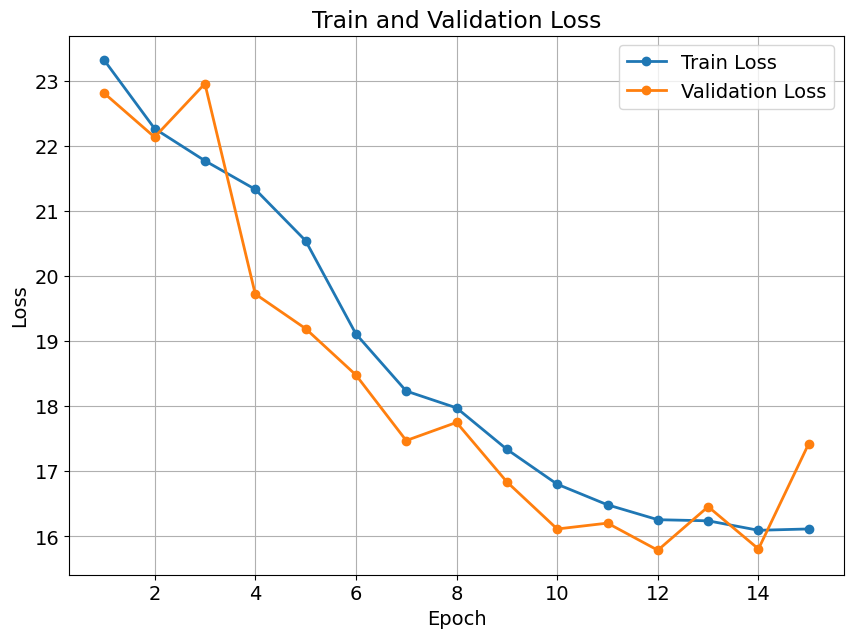

In [42]:
plt.plot(epochs, train_loss , 'o-' , label = 'Train Loss' )
plt.plot(epochs, valid_loss , 'o-' , label = 'Validation Loss')
plt.grid()
plt.title('Train and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

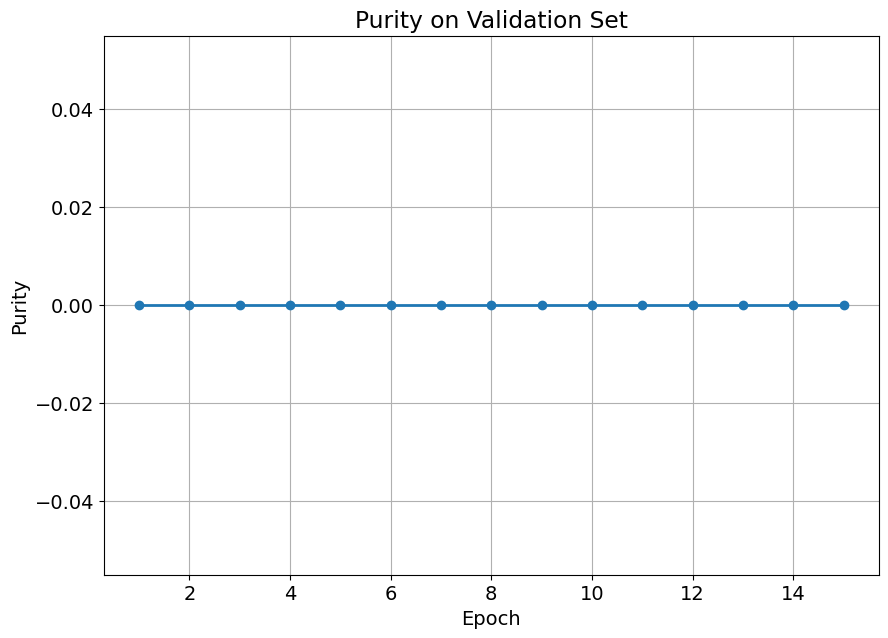

In [43]:
plt.plot(epochs, valid_purity , 'o-' )
plt.grid()
plt.title('Purity on Validation Set')
plt.xlabel('Epoch')
plt.ylabel('Purity')
plt.show()

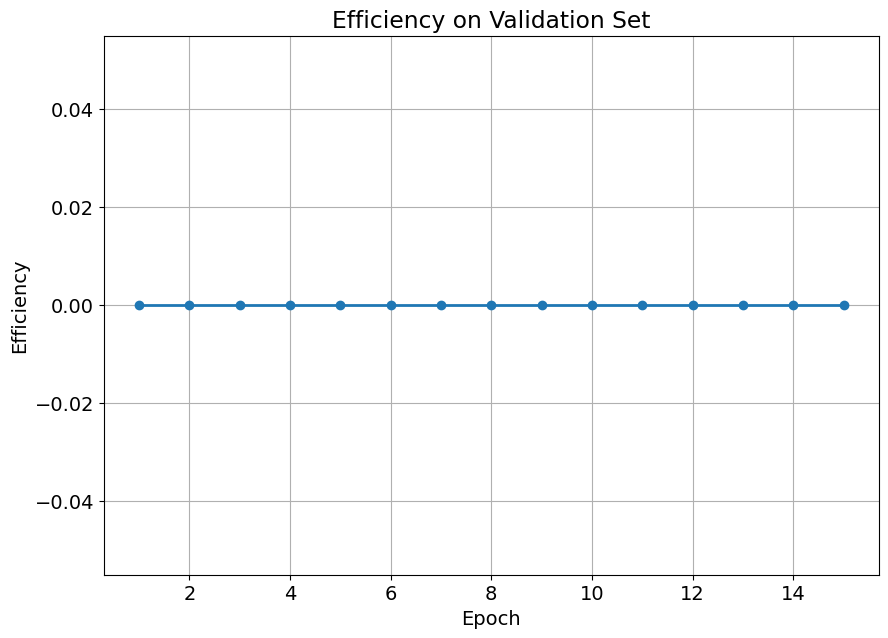

In [44]:
plt.plot(epochs, valid_efficiency , 'o-'  )
plt.grid()
plt.title('Efficiency on Validation Set')
plt.xlabel('Epoch')
plt.ylabel('Efficiency')
plt.show()